### 基于内容的推荐机制

在上个 notebook 中，我们介绍了如何使用协同过滤进行推荐。但是如果使用该技巧，有很多用户根本无法获得任何推荐电影。还有一些用户获得的推荐电影不到函数设置的十部电影上限。

为了向这些用户做出推荐，我们将尝试另一个技巧：**基于内容的**推荐机制。我们接着上个 notebook 继续。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import HTML
import progressbar
import tests as t
import pickle


%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']


all_recs = pickle.load(open("all_recs.p", "rb"))

### 数据集

现在你可以访问将在这个 notebook 的后续部分一直使用的以下三大项了。  

`a.` **movies** - 一个 DataFrame，其中包含数据集中的所有电影，以及关于电影的其他内容相关信息（类型和日期）


`b.` **reviews** - 它是之前协同过滤使用的主要DataFrame，其中包含用户和电影之间的所有互动。


`c.` **all_recs** - 一个字典，每个键都是一个用户，值是基于协同过滤推荐的电影列表

对于 **all_recs** 中使用协同过滤收到十部推荐电影的用户，我们不需要处理他们。但是，数据集中还有很多用户没有获得任何电影推荐。

-----

`1.` 首先，我们将查找数据集中没有收到本因为协同过滤而能够获得的 10 部推荐电影的所有用户。

In [2]:
users_with_all_recs = []
for user, movie_recs in all_recs.items():
    if len(movie_recs) > 9:
        users_with_all_recs.append(user)

print("There are {} users with all reccomendations from collaborative filtering.".format(len(users_with_all_recs)))

users = np.unique(reviews['user_id'])
users_who_need_recs = np.setdiff1d(users, users_with_all_recs)

print("There are {} users who still need recommendations.".format(len(users_who_need_recs)))
print("This means that only {}% of users received all 10 of their recommendations using collaborative filtering".format(round(len(users_with_all_recs)/len(np.unique(reviews['user_id'])), 4)*100))   

There are 22187 users with all reccomendations from collaborative filtering.
There are 31781 users who still need recommendations.
This means that only 41.11% of users received all 10 of their recommendations using collaborative filtering


In [3]:
# A quick test
assert len(users_with_all_recs) == 22187
print("That's right there were still another 31781 users who needed recommendations when we only used collaborative filtering!")

That's right there were still another 31781 users who needed recommendations when we only used collaborative filtering!


### 基于内容的推荐机制

这一次，你将混合使用内容和协同过滤向用户推荐电影。这样能够在之前无法做出推荐的很多情形下获得电影推荐。     

`2.` 在查找推荐电影之前，先从高到低地对用户的评分进行排序。你将按照此顺序遍历 movies 并寻找其他相似的电影。

In [4]:
# create a dataframe similar to reviews, but ranked by rating for each user
ranked_reviews = reviews.sort_values(by=['user_id', 'rating'], ascending=False)

### 相似性

在协同过滤部分，你掌握了计算两个用户之间相似性（或距离）的多种方法。我们可以按照几乎相同的方法基于内容计算相似性。  

在很多情形下，计算项目之间相似性的最快速方法是使用矩阵乘法，前提是矩阵不像之前那样很稀疏。如果你不了解这种方法，请观看此 [3blue1brown 视频](https://www.youtube.com/watch?v=LyGKycYT2v0)，并且[这篇帖子](https://math.stackexchange.com/questions/689022/how-does-the-dot-product-determine-similarity)简单介绍了此方法。

要提取从内容角度描述 DateFrame 中电影的矩阵，我们可以使用与**年份**和**类型**相关的指示变量。  

然后对此矩阵及它本身进行点积运算，获得电影之间相似性的矩阵注意，在以下矩阵乘法中，如果值 1 相互重叠，那么结果是 2，表明相似性很高。在第二个点积中，值 1 不重叠。所以点积结果是 0，表示相似性很低。

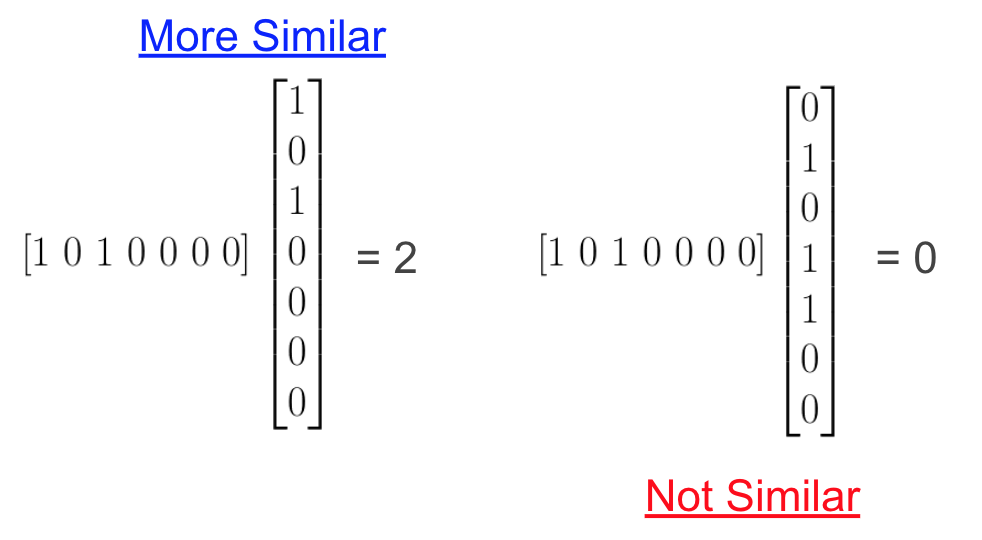

我们可以根据内容特征对电影矩阵进行点积运算，获得电影x电影矩阵，其中每个单元格表示两部电影之间的相似度。在下图中，可以看出，对于这部分数据来说，电影 1 与电影 8 最相似，电影 2 与电影 8 最相似，电影 3 与电影 9 最相似。矩阵对角线上的元素将表示电影与其本身的相似性，相似性肯定最高（并且将对应于原始电影内容矩阵中电影行里的数字 1）

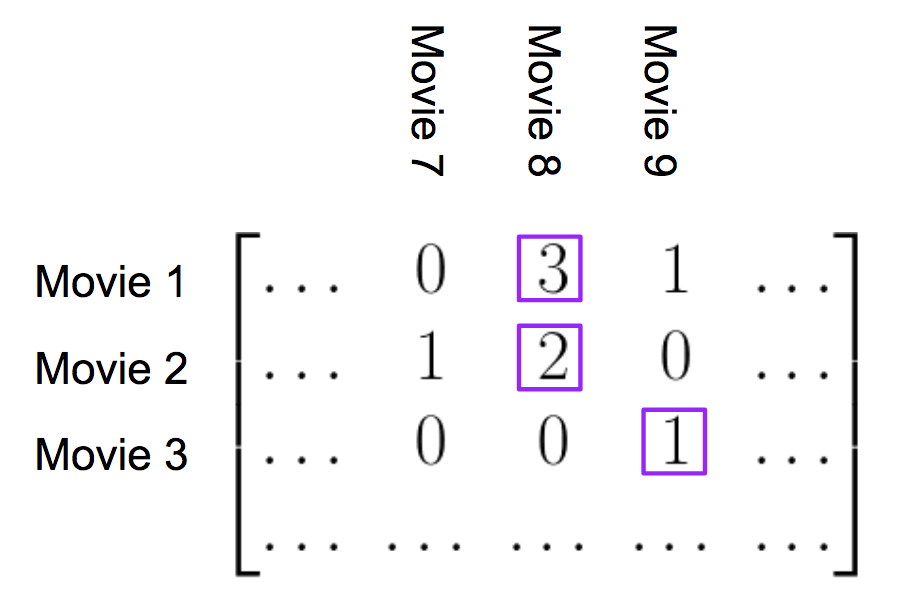


`3.` 请创建一个 NumPy 数组，它是一个与电影年份（按年代划分）和电影类型相关的指示变量矩阵。请计算此矩阵与其本身（转置后）的点积，得出每部电影与所有其他电影的相似性矩阵。最终矩阵应该是 31245 x 31245。

In [5]:
# Subset so movie_content is only using the dummy variables for each genre and the 3 century based year dummy columns
movie_content = np.array(movies.iloc[:,4:])

# Take the dot product to obtain a movie x movie matrix of similarities
dot_prod_movies = movie_content.dot(np.transpose(movie_content))

In [6]:
# create checks for the dot product matrix
assert dot_prod_movies.shape[0] == 31245
assert dot_prod_movies.shape[1] == 31245
assert dot_prod_movies[0, 0] == np.max(dot_prod_movies[0])
print("Looks like you passed all of the tests.  Though they weren't very robust - if you want to write some of your own, I won't complain!")

Looks like you passed all of the tests.  Though they weren't very robust - if you want to write some of your own, I won't complain!


### 对于每位用户...


你已经有一个矩阵，其中每个用户的评分都已排序。还有另一个矩阵，其中每个轴表示电影，如果两部电影更相似，那么矩阵条目更大，如果不相似，则矩阵条目更小。这个矩阵衡量的是内容相似性。下面到了有趣的环节了。

对于每个用户，我们将执行以下操作：

i. 对于每部电影，查找最相似且用户没看过的电影。

ii.继续查找已评分电影，直到推荐 10 部电影或没有可推荐的其他电影。

最后提示下，你可能需要调整“最相似”条件，才能获得 10 部推荐电影。第一遍我仅使用了相互之间相似性最高的电影作为推荐电影。

`3.` 在以下单元格中，请完成以下每个函数，从而基于内容做出推荐。

In [7]:
def find_similar_movies(movie_id):
    '''
    INPUT
    movie_id - a movie_id 
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    # find the row of each movie id
    movie_idx = np.where(movies['movie_id'] == movie_id)[0][0]
    
    # find the most similar movie indices - to start I said they need to be the same for all content
    similar_idxs = np.where(dot_prod_movies[movie_idx] == np.max(dot_prod_movies[movie_idx]))[0]
    
    # pull the movie titles based on the indices
    similar_movies = np.array(movies.iloc[similar_idxs, ]['movie'])
    
    return similar_movies
    
    
def get_movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies['movie_id'].isin(movie_ids)]['movie'])
   
    return movie_lst

def make_recs():
    '''
    INPUT
    None
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    # Create dictionary to return with users and ratings
    recs = defaultdict(set)
    # How many users for progress bar
    n_users = len(users)

    
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    # For each user
    for user in users:
        
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)

        # Pull only the reviews the user has seen
        reviews_temp = ranked_reviews[ranked_reviews['user_id'] == user]
        movies_temp = np.array(reviews_temp['movie_id'])
        movie_names = np.array(get_movie_names(movies_temp))

        # Look at each of the movies (highest ranked first), 
        # pull the movies the user hasn't seen that are most similar
        # These will be the recommendations - continue until 10 recs 
        # or you have depleted the movie list for the user
        for movie in movies_temp:
            rec_movies = find_similar_movies(movie)
            temp_recs = np.setdiff1d(rec_movies, movie_names)
            recs[user].update(temp_recs)

            # If there are more than 
            if len(recs[user]) > 9:
                break

    bar.finish()
    
    return recs

In [8]:
recs = make_recs()

[========================================================================] 100%


### 推荐效果如何？

做出推荐之后，向每个人提供一组推荐电影的效果如何？

`4.` 请通过以下单元格查看你能够向多少用户推荐电影，并看看无法向其推荐电影的用户有哪些特性。

In [9]:
# Explore recommendations
users_without_all_recs = []
users_with_all_recs = []
no_recs = []
for user, movie_recs in recs.items():
    if len(movie_recs) < 10:
        users_without_all_recs.append(user)
    if len(movie_recs) > 9:
        users_with_all_recs.append(user)
    if len(movie_recs) == 0:
        no_recs.append(user)

In [11]:
# Some characteristics of my content based recommendations
print("There were {} users without all 10 recommendations we would have liked to have.".format(len(users_without_all_recs)))
print("There were {} users with all 10 recommendations we would like them to have.".format(len(users_with_all_recs)))
print("There were {} users with no recommendations at all!".format(len(no_recs)))

There were 2179 users without all 10 recommendations we would have liked to have.
There were 51789 users with all 10 recommendations we would like them to have.
There were 174 users with no recommendations at all!


In [12]:
# Closer look at individual user characteristics - this may help it was from an earlier notebook
user_items = reviews[['user_id', 'movie_id', 'rating']]
user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    movies = user_by_movie.loc[user_id][user_by_movie.loc[user_id].isnull() == False].index.values

    return movies


movies_watched(189)

array([457430])

In [13]:
cnter = 0
print("Some of the movie lists for users without any recommendations include:")
for user_id in no_recs:
    print(user_id)
    print(get_movie_names(movies_watched(user_id)))
    cnter+=1
    if cnter > 10:
        break

Some of the movie lists for users without any recommendations include:
189
['El laberinto del fauno (2006)']
797
['The 414s (2015)']
1603
['Beauty and the Beast (2017)']
2056
['Brimstone (2016)']
2438
['Baby Driver (2017)']
3322
['Rosenberg (2013)']
3925
['El laberinto del fauno (2006)']
4325
['Beauty and the Beast (2017)']
4773
['The Frozen Ground (2013)']
4869
['Beauty and the Beast (2017)']
4878
['American Made (2017)']


### 下一步？  

如果你依然坚持采用一开始的电影相似性条件（就像我一开始那样），那么有些用户依然无法获得 10 部推荐电影（还有一小部分用户根本没有任何推荐电影）。 

我们之前就提到了，推荐引擎不仅是一门**科学**，而且是一项**艺术**。还有很多问题值得探索：协同过滤和基于内容的推荐机制相比如何？如何结合用户输入与协同过滤和/或基于内容的推荐来改进任何推荐系统？如何真正地为每位用户提供推荐内容？

`5.` 在最后一步，对于我们到目前为止介绍过的推荐技巧，你可以随意探索你的最后想法。你可能会选择对排名靠前的电影应用第一个技巧，并作出最后的推荐。你还可能会降低判定电影之间相似性的条件。大胆创新吧，别忘了与其他同学分享你的创意哦！

In [ ]:
# Cells for exploring

```python

```